In [251]:
# load spacy and english dictionary
import spacy


nlp = spacy.load('en')

from nltk.stem import SnowballStemmer

newstop = ['the', 'v.', '-pron-', 'court', '\'s', 'state', 'case', 'district', 'in', 's.ct', 'co.', 'l.ed.2d', 'u.s.', 'l.ed']
stemmer = SnowballStemmer('english')

for s in newstop:
    nlp.vocab[s].is_stop = True

def clean_document(doc):
    def token_nok(token):
        return token.text == "," or token.is_stop or token.is_punct or token.is_space or token.is_digit
    doc = [token.lemma_.lower() for token in doc if not token_nok(token)]
    doc = [stemmer.stem(t) for t in doc if t not in newstop]
    return doc


In [203]:
# load N cases

from os import listdir
N = 500
case_path = 'data/cases'
all_cases = listdir(case_path)
doc_cases = []

for i in range(len(all_cases[:N])):
    if (i % 10 == 0): print('{}%'.format(int(100/len(all_cases[:N])*i)), end=', ')
    
    case_0_name = '{}/{}'.format(case_path, all_cases[i])
    case_0 = open(case_0_name, 'r').read()
    doc = nlp(case_0)
    
    doc_cases.append(doc)

0%, 2%, 4%, 6%, 8%, 10%, 12%, 14%, 16%, 18%, 20%, 22%, 24%, 26%, 28%, 30%, 32%, 34%, 36%, 38%, 40%, 42%, 44%, 46%, 48%, 50%, 52%, 54%, 56%, 58%, 60%, 62%, 64%, 66%, 68%, 70%, 72%, 74%, 76%, 78%, 80%, 82%, 84%, 86%, 88%, 90%, 92%, 94%, 96%, 98%, 

In [204]:
# Load metadata of corresponding cases

import pandas as pd
import re

case_reversed = pd.read_csv('data/case_metadata.csv')
case_reversed.head()

pd_all_cases = pd.DataFrame(columns=case_reversed.columns)

for i in range(len(all_cases[:N])):
    if (i % 10 == 0): print('{}%'.format(int(100/len(all_cases[:N])*i)), end=', ')

    file_name = all_cases[i]
    case_id = re.findall(r'[A-Z]+[A-Z0-9]*',file_name)[0]
    Y = case_reversed.loc[case_reversed['caseid'] == case_id]
    pd_all_cases = pd_all_cases.append(Y)
    
pd_all_cases.head()

0%, 2%, 4%, 6%, 8%, 10%, 12%, 14%, 16%, 18%, 20%, 22%, 24%, 26%, 28%, 30%, 32%, 34%, 36%, 38%, 40%, 42%, 44%, 46%, 48%, 50%, 52%, 54%, 56%, 58%, 60%, 62%, 64%, 66%, 68%, 70%, 72%, 74%, 76%, 78%, 80%, 82%, 84%, 86%, 88%, 90%, 92%, 94%, 96%, 98%, 

,caseid,case_reversed,judge_id,year,log_cites
347,X4AO5K,0,1299.0,1938.0,0.693147
2573,X408IB,1,NaN,NaN,NaN
4449,X3A3AG,1,1316.0,1988.0,1.791759
2676,X47PVI,1,1006.0,1942.0,0.693147
3628,X45JNN,1,628.0,1970.0,1.791759


In [252]:
# CREATE TRIGRAMS



def get_ngrams(doc, n=3):
    trigrams = []
    current_trigram = []
    for token in doc:
        if token.text == "," or token.is_stop or token.is_punct or token.is_space or token.is_digit: continue
        if token.text.lower() in newstop: continue
        current_trigram.append(stemmer.stem(token.lemma_))
        
        if token.pos_ == "NOUN":
            if len(current_trigram) == n:
                trigrams.append(tuple(current_trigram))
                current_trigram = []
        if len(current_trigram) > n-1:
            current_trigram.pop(0)
    return trigrams


all_trigrams = {}
for i in range(len(doc_cases)):
    if (i % 10 == 0): print('{}%'.format(int(100/len(all_cases[:N])*i)), end=', ')
    
    for ngram in get_ngrams(doc_cases[i]):
        if ngram not in all_trigrams:
            all_trigrams[ngram]  = 1
        else:
            all_trigrams[ngram] += 1
            
    for ngram in get_ngrams(doc_cases[i], n=2):
        if ngram not in all_trigrams:
            all_trigrams[ngram]  = 1
        else:
            all_trigrams[ngram] += 1


0%, 2%, 4%, 6%, 8%, 10%, 12%, 14%, 16%, 18%, 20%, 22%, 24%, 26%, 28%, 30%, 32%, 34%, 36%, 38%, 40%, 42%, 44%, 46%, 48%, 50%, 52%, 54%, 56%, 58%, 60%, 62%, 64%, 66%, 68%, 70%, 72%, 74%, 76%, 78%, 80%, 82%, 84%, 86%, 88%, 90%, 92%, 94%, 96%, 98%, 

In [253]:
F_MAP_SIZE = 1000

# We take F_MAP_SIZE biggest trigrams as features 
bigger = 0
for (key, val) in all_trigrams.items():
    bigger += (val > 1)

all_trigrams_list = list(all_trigrams.items())

    
print(bigger, " of ", len(all_trigrams))

all_trigrams_list.sort(key=(lambda t : t[1] ))
features = all_trigrams_list[-F_MAP_SIZE:]
features_map = {k:i for i,(k,v) in enumerate(features)}

41391  of  296462


In [254]:
all_trigrams_list[-5:]

[(('constitut', 'right'), 223),
 (('collect', 'bargain'), 229),
 (('legisl', 'histori'), 261),
 (('common', 'law'), 298),
 (('grand', 'juri'), 300)]

In [256]:
# Transform data into numpy

import numpy as np

# Now map cases to feature maps
X = np.zeros((N, F_MAP_SIZE))
Y = np.zeros(N)

for i in range(len(doc_cases)):
    if (i % 10 == 0): print('{}%'.format(int(100/len(all_cases[:N])*i)), end=', ')
    Y[i] = int(pd_all_cases.iloc[i]['case_reversed'])

    for ngram in get_ngrams(doc_cases[i]):
        if ngram in features_map:
            X[i, features_map[ngram]] += 1
            
    for ngram in get_ngrams(doc_cases[i], n=2):
        if ngram in features_map:
            X[i, features_map[ngram]] += 1



0%, 2%, 4%, 6%, 8%, 10%, 12%, 14%, 16%, 18%, 20%, 22%, 24%, 26%, 28%, 30%, 32%, 34%, 36%, 38%, 40%, 42%, 44%, 46%, 48%, 50%, 52%, 54%, 56%, 58%, 60%, 62%, 64%, 66%, 68%, 70%, 72%, 74%, 76%, 78%, 80%, 82%, 84%, 86%, 88%, 90%, 92%, 94%, 96%, 98%, 

In [257]:
###############################################
############          1         ###############
###############################################

# SPLIT Data into training and test and run logistic regression on it

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [258]:
# Use GridSearchCV to find correct parameters
from sklearn.model_selection import GridSearchCV

parameters = {'penalty':['l2', 'l1'] ,'C':[0.1, 0.5, 1, 5]}
logistic = LogisticRegression(random_state=0, solver='liblinear')

clf = GridSearchCV(logistic, parameters, cv=5)
clf.fit(X_train, y_train)

clf.best_estimator_

/home/simi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [259]:
clf.best_score_

0.6288888888888889

In [260]:
from sklearn.model_selection import cross_val_predict
# Take your best-performing logistic regression model from Problem Set 1
# 1:  Use cross_val_predict() to form model predictions for each observation.
y_predicted = cross_val_predict(clf.best_estimator_, X_test, y_test, cv=5)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_predicted)

array([[13,  1],
       [35,  1]])

In [261]:
# 2 Report the precision_recall_curve() 
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision_recall_curve(y_test, y_predicted)


(array([0.72, 0.5 , 1.  ]),
 array([1.        , 0.02777778, 0.        ]),
 array([0., 1.]))

In [262]:
# and roc_curve()

from sklearn.metrics import roc_curve

roc_curve(y_test, y_predicted)

(array([0.        , 0.07142857, 1.        ]),
 array([0.        , 0.02777778, 1.        ]),
 array([2., 1., 0.]))

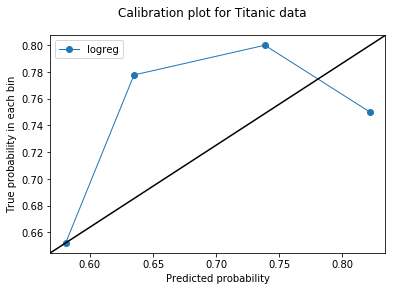

In [263]:
# Make a calibration plot (as in Bansak et al 2018, appendix page 24).
logreg = clf.best_estimator_
logreg_prediction = logreg.predict_proba(X_test)

from sklearn.calibration import calibration_curve
logreg_y, logreg_x = calibration_curve(y_test, logreg_prediction[:,1], n_bins=10)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='logreg')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for Titanic data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

In [136]:
###############################################
############          2         ###############
###############################################
# Scale your n-gram frequencies while maintaining sparsity, as discussed in class.  

# ??? 


In [266]:
# Train an elastic net model to predict log citations to a case (log_cites). 

# CREATE DATA
X_cites = np.zeros((N, F_MAP_SIZE))
Y_cites = np.zeros(N).astype(np.float64)

counter = 0
for i in range(len(doc_cases)):
    if (i % 10 == 0): print('{}%'.format(int(100/len(all_cases[:N])*i)), end=', ')
    if np.isnan(pd_all_cases.iloc[i]['log_cites']): continue

    Y_cites[counter] = pd_all_cases.iloc[i]['log_cites']

    for ngram in get_trigrams(doc_cases[i]):
        if ngram in features_map:
            X_cites[counter, features_map[ngram]] += 1
            
    for ngram in get_ngrams(doc_cases[i], n=2):
        if ngram in features_map:
            X_cites[counter, features_map[ngram]] += 1
    counter += 1

X_cites = X_cites[:counter, :]
Y_cites = Y_cites[:counter]
    
"""



Run cross_val_predict() to form model predictions and report a scatter plot of true and predicted values. 
"""

0%, 2%, 4%, 6%, 8%, 10%, 12%, 14%, 16%, 18%, 20%, 22%, 24%, 26%, 28%, 30%, 32%, 34%, 36%, 38%, 40%, 42%, 44%, 46%, 48%, 50%, 52%, 54%, 56%, 58%, 60%, 62%, 64%, 66%, 68%, 70%, 72%, 74%, 76%, 78%, 80%, 82%, 84%, 86%, 88%, 90%, 92%, 94%, 96%, 98%, 

'\n\n\n\nRun cross_val_predict() to form model predictions and report a scatter plot of true and predicted values. \n'

In [267]:
X_cites_train, X_cites_test, y_cites_train, y_cites_test = train_test_split(X_cites, Y_cites, test_size=0.1, random_state=42)

In [268]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=0)
regr.fit(X_cites_train, y_cites_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

Text(0,0.5,'Predicted')

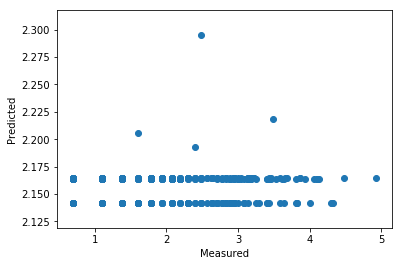

In [269]:
# Run cross_val_predict() to form model predictions and report a scatter plot of true and predicted values. 
y_pred = cross_val_predict(regr, X_cites_train, y_cites_train, cv=3)
fig, ax = plt.subplots()
ax.scatter(y_cites_train, y_pred)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

In [270]:
###############################################
############          3         ###############
################################################ 
# Use the judge identifiers (judge_id) to produce the average citations to cases for each judge.
pd_all_cases_non_nan = pd_all_cases.dropna()
mean_by_id = pd_all_cases_non_nan.groupby('judge_id')['log_cites'].agg(['mean'])
mean_by_id.head()

,mean
judge_id,
5.0,2.079442
14.0,2.302585
22.0,2.021526
37.0,2.302585
39.0,2.302585


In [271]:
# Then estimate a two-stage least-squares model with Z as average citations of the judge, 
# X as citations to the case, and Y as whether the case was reversed. 

# replace judge id by average_citations 
pd.options.mode.chained_assignment = None  # default='warn'

for i in range(mean_by_id.shape[0]):
    judge_id = mean_by_id.iloc[i].name
    mean_val = float(mean_by_id.iloc[i]['mean'])
    mask = pd_all_cases_non_nan['judge_id'] == judge_id
    pd_all_cases_non_nan.loc[mask, 'judge_id'] = mean_val


In [272]:
# X as citations to the case
X_citations = pd_all_cases_non_nan['log_cites'].values.astype(np.float32)
# Z as average citations of the judge
Z_avg_citations = pd_all_cases_non_nan['judge_id'].values.astype(np.float32)
# Y cases reversed
Y_case_reversed = pd_all_cases_non_nan['case_reversed'].values.astype(np.int32)

In [273]:
Z_avg_citations = Z_avg_citations.reshape(-1, 1)

Z = np.hstack((Z_avg_citations, np.ones((Z_avg_citations.shape[0], 1))))
# step 1: X = Zb

b = np.linalg.lstsq(Z, X_citations)
b,c0 = b[0], b[1]

X_tilde = np.dot(Z, b) + c0
X_tilde = X_tilde.reshape(-1,1)

# Include year fixed effects. Report estimates for coefficient 
print('coefficients LS1:')
print(b, c0)

coefficients LS1:
[9.99999997e-01 9.43153827e-09] [92.58380758]


/home/simi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [274]:
# Step 2: Y = X_tilde*a
X_tilde = np.hstack((X_tilde, np.ones((X_tilde.shape[0], 1))))

a = np.linalg.lstsq(X_tilde, Y_cites.reshape(-1,1))
a,c1 = a[0], a[1]

Y_pred_ = np.dot(X_tilde, a)

print('coefficients LS2:')
print(a)

coefficients LS2:
[[  1.        ]
 [-92.58380763]]


/home/simi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [275]:
# and standard error on X.

lsqe = np.power(Y_cites.reshape(-1,1) - Y_pred_, 2)
lsqe_sum = np.mean(lsqe)
print("Mean squared error: ")
print(lsqe_sum)
print("Standard error: ")
stde = np.sqrt(lsqe_sum) / np.sqrt(lsqe.shape[0])
print(stde)


Mean squared error: 
0.23262263089509597
Standard error: 
0.02417599991930491


In [276]:
###############################################
############          4         ###############
###############################################
# Train LDA on the cases. Produce word clouds 

from nltk.stem import SnowballStemmer

newstop = ['the', 'v.', '-pron-', 'court', '\'s', 'state', 'case', 'district', 'in', 's.ct']
stemmer = SnowballStemmer('english')

for s in newstop:
    nlp.vocab[s].is_stop = True

def clean_document(doc):
    def token_nok(token):
        return token.text == "," or token.is_stop or token.is_punct or token.is_space or token.is_digit
    doc = [token.lemma_.lower() for token in doc if not token_nok(token)]
    doc = [stemmer.stem(t) for t in doc if t not in newstop]
    return doc
doc_clean = [clean_document(doc) for doc in doc_cases]





In [277]:
# creating the term dictionary
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)

# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# train LDA with 10 topics and print
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=3, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=False)


[(0,
  [('u.s.', 0.0054437025),
   ('law', 0.0052412665),
   ('act', 0.0051409216),
   ('defend', 0.0044927048),
   ('feder', 0.004220956),
   ('claim', 0.0041653286),
   ('f.2d', 0.003913963),
   ('action', 0.003873436),
   ('rule', 0.0038320313),
   ('govern', 0.0038006925)]),
 (1,
  [('unit', 0.00680511),
   ('u.s.', 0.006178383),
   ('state', 0.0060785315),
   ('act', 0.0058696703),
   ('appel', 0.005626984),
   ('defend', 0.0047548446),
   ('juri', 0.004403074),
   ('order', 0.004278277),
   ('claim', 0.004160201),
   ('f.2d', 0.004117099)]),
 (2,
  [('u.s.', 0.0071481136),
   ('act', 0.0071391496),
   ('requir', 0.0050707604),
   ('unit', 0.00487437),
   ('law', 0.004780884),
   ('state', 0.004765056),
   ('section', 0.0042487993),
   ('claim', 0.004180288),
   ('defend', 0.004153287),
   ('right', 0.0039490988)])]

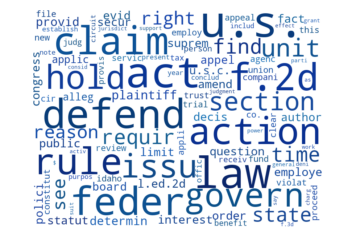

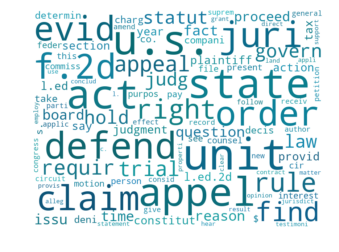

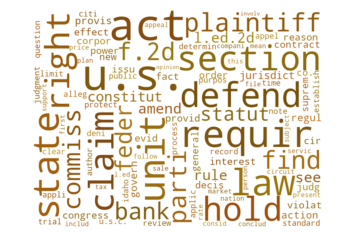

In [278]:
###
# LDA Word Clouds
###

# for the topics. Inspect the word clouds for different models to decide on the right number of topic

from numpy.random import randint
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# make directory if not exists
from os import mkdir
try:
    mkdir('lda')
except:
    pass

# make word clouds for the topics
for i,weights in lda.show_topics(num_topics=-1,
                                 num_words=100,
                                 formatted=False):
    
    #logweights = [w[0], np.log(w[1]) for w in weights]
    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None, 
                  position=None, orientation=None, 
                  font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [280]:
###############################################
############          5         ###############
###############################################
#  Replicate your sklearn logistic regression model 
# (no hidden layers, L2 regularization, and softmax output layer) in Keras or some other deep learning library. 
# Compare performance. 

import torch
import torch.nn as nn
import torch.nn.functional as F


# Model
class SimpleLogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return F.softmax(out)


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)    

input_size = X_train.shape[1]
num_classes = 2

device = torch.device('cuda')

model = SimpleLogisticRegression(input_size, num_classes)
model.to(device)

# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.1)  



# Training the Model
for epoch in range(10):
    np.random.shuffle(X_train)
    for i in range(X_train.shape[0]):
        
        data = torch.as_tensor(X_train[i:i+10].reshape(-1, F_MAP_SIZE )).float().to(device)
        labels = torch.as_tensor(y_train[i:i+10]).long().to(device)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()
        

# Test the Model
correct = 0
total = 0
for i in range(X_test.shape[0]):

    data = torch.as_tensor(X_test[i].reshape(-1, F_MAP_SIZE)).float().to(device)
    labels = torch.as_tensor(y_test[i]).long().to(device).view(-1)
    
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy: %d %%' % (100 * correct / total))


/home/simi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 66 %


In [288]:
# Now add two hidden layers, dropout, and batch normalization. Compare performance.

# Model
class NotSimpleLogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NotSimpleLogisticRegression, self).__init__()
        
        self.hidden1 = nn.Linear(input_size, 100)
        self.dropout = nn.Dropout()
        self.hidden2 = nn.Linear(100, 50)
        self.dense1_bn = nn.BatchNorm1d(50)
        self.linear = nn.Linear(50, num_classes)
    
    def forward(self, x):
        o1 = self.hidden1(x)
        o2 = self.dropout(o1)
        o3 = self.hidden2(o2)
        o4 = self.dense1_bn(o3)
        out = self.linear(o4)
        return F.softmax(out)


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)    

input_size = F_MAP_SIZE
num_classes = 2

device = torch.device('cuda')

model = NotSimpleLogisticRegression(input_size, num_classes)
model.to(device)

# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.1)  

model.train()

# Training the Model
for epoch in range(10):
    np.random.shuffle(X_train)
    for i in range(X_train.shape[0]):
        
        data = torch.as_tensor(X_train[i:i+10].reshape(-1, F_MAP_SIZE)).float().to(device)
        labels = torch.as_tensor(y_train[i:i+10]).long().to(device)
        
        if i > X_train.shape[0] -10:
            break
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()

model.eval()

# Test the Model
correct = 0
total = 0
for i in range(X_test.shape[0]):

    data = torch.as_tensor(X_test[i].reshape(-1, F_MAP_SIZE)).float().to(device)
    labels = torch.as_tensor(y_test[i]).long().to(device).view(-1)
    
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy: %d %%' % (100 * correct / total))

/home/simi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 72 %
